<a href="https://colab.research.google.com/github/ha2040/Deep-Learning/blob/main/TwitterSentimentAnalysisCovid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hafiz Saley

# Twitter sentiment analysis project

This project was chosen to encourage me to learn how to deal with textual data for deep learning from scratch, and to then be able to build a model that can be used to analyze the sentiment of tweets (or on any other social media for that matter). It is a solid way of teaching myself how to solve an NLP-task.

# Imports

In [ ]:
from google.colab import files
import pandas as pd
import tensorflow as tf
import numpy as np
from google.colab import autoviz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

import keras

import tensorflow as tf

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import TextVectorization
from nltk import pos_tag
import time

from collections import Counter

# Setup dataset from kaggle

In [ ]:
!pip install q kaggle

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"droppise","key":"00cf2e5d8a61b1589e5045889cec6d3e"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                              title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
hummaamqaasim/jobs-in-data                                       Jobs and Salaries in Data Science            76KB  2023-12-25 20:03:32           4676         86  1.0              
jacksondivakarr/car-crash-dataset                                Car Crash Dataset                             4MB  2024-01-08 13:44:08           1479         36  1.0              
thedrcat/daigt-v2-train-dataset                                  DAIGT V2 Train Dataset                       29MB  2023-11-16 01:38:36           3982        309  1.0              
vishakhdapat/price-of-used-toyota-corolla-cars                   Price of Used Toyota Corolla C

In [ ]:
!kaggle datasets download -d datatattle/covid-19-nlp-text-classification/

 91% 4.00M/4.38M [00:00<00:00, 6.01MB/s]
100% 4.38M/4.38M [00:00<00:00, 4.70MB/s]


In [ ]:
! unzip /content/covid-19-nlp-text-classification.zip

Archive:  /content/covid-19-nlp-text-classification.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


In [ ]:
df = pd.read_csv("/content/Corona_NLP_train.csv", encoding_errors='ignore')

In [ ]:
df_test = pd.read_csv("/content/Corona_NLP_test.csv", encoding_errors='ignore')

# Basic analysis on the dataset

Here we check the fields for our dataset and for any null values and duplicated rows.

In [ ]:
df.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_test.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [ ]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

In [ ]:
df_test.isnull().sum()

UserName           0
ScreenName         0
Location         834
TweetAt            0
OriginalTweet      0
Sentiment          0
dtype: int64

In [ ]:
df.duplicated().value_counts()

False    41157
dtype: int64

## Drop unnecessary columns & Rename Columns
The column names are not properly named, so we will rename them to fit the intended dataset column format.



In [ ]:
df.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [ ]:
# Drop unnecessary columns
df = df.drop(['UserName',	'ScreenName',	'Location',	'TweetAt'], axis=1)

In [ ]:
df_test = df_test.drop(['UserName',	'ScreenName',	'Location',	'TweetAt'], axis=1)

In [ ]:
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_test.head()

,OriginalTweet,Sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
df.rename(columns = {'OriginalTweet': 'text', "Sentiment": 'sentiment' },  inplace = True)

In [ ]:
df_test.rename(columns = {'OriginalTweet': 'text', "Sentiment": 'sentiment' },  inplace = True)

In [ ]:
df.head()

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
df_test.head()

,text,sentiment
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,When I couldn't find hand sanitizer at Fred Me...,Positive
2,Find out how you can protect yourself and love...,Extremely Positive
3,#Panic buying hits #NewYork City as anxious sh...,Negative
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


[]

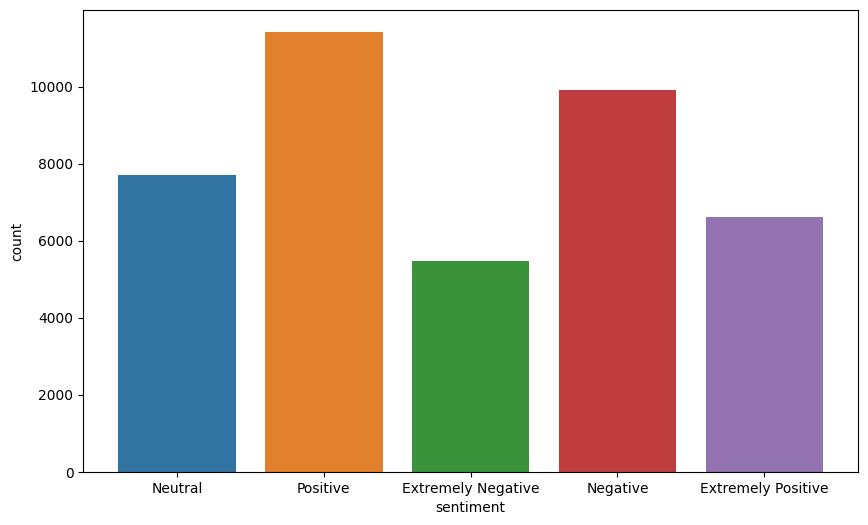

In [ ]:
plt.figure(figsize=[10, 6])
sns.countplot(x= df["sentiment"], data=df)
plt.plot()

# Preprocessing data

## Replace "Extremely Positive" with "Positive" and "Extremely Negative" with "Negative" resulting in only 3 types of sentiment

In [ ]:
# Replace "Extremely Positive" with "Positive"
df['sentiment'] = df['sentiment'].replace('Extremely Positive', 'Positive')

# Replace "Extremely Negative" with "Negative"
df['sentiment'] = df['sentiment'].replace('Extremely Negative', 'Negative')

# Replace "Extremely Positive" with "Positive"
df_test['sentiment'] = df_test['sentiment'].replace('Extremely Positive', 'Positive')

# Replace "Extremely Negative" with "Negative"
df_test['sentiment'] = df_test['sentiment'].replace('Extremely Negative', 'Negative')

In [ ]:
print(df.sentiment.value_counts())

Positive    18046
Negative    15398
Neutral      7713
Name: sentiment, dtype: int64


In [ ]:
print(df_test.sentiment.value_counts())

Negative    1633
Positive    1546
Neutral      619
Name: sentiment, dtype: int64


[]

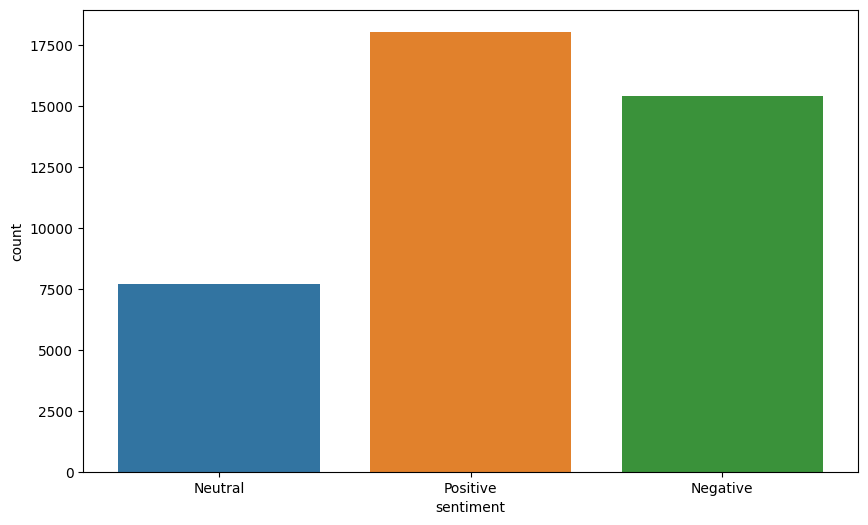

In [ ]:
plt.figure(figsize=[10, 6])
sns.countplot(x= df["sentiment"], data=df)
plt.plot()

### View neutral, positive and negative tweets

In [ ]:
df[df['sentiment'] == 'Neutral'].head(10)

,text,sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
7,Was at the supermarket today. Didn't buy toile...,Neutral
10,All month there hasn't been crowding in the su...,Neutral
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral
17,@eyeonthearctic 16MAR20 Russia consumer survei...,Neutral
21,https://t.co/AVKrR9syff\r\r\n\r\r\nThe COVID-1...,Neutral
32,Retail store closures could explode because of...,Neutral
35,Went to the supermarket yesterday and the toil...,Neutral
43,Breaking Story: Online clothes shopping rises ...,Neutral
44,This is the line outside @Target in as custo...,Neutral


In [ ]:
df[df['sentiment'] == 'Positive'].head(10)

,text,sentiment
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
5,As news of the regions first confirmed COVID-...,Positive
6,Cashier at grocery store was sharing his insig...,Positive
8,Due to COVID-19 our retail store and classroom...,Positive
11,"Due to the Covid-19 situation, we have increas...",Positive
12,#horningsea is a caring community. Lets ALL l...,Positive
13,"Me: I don't need to stock up on food, I'll jus...",Positive
14,ADARA Releases COVID-19 Resource Center for Tr...,Positive


In [ ]:
df[df['sentiment'] == 'Negative'].head(10)

,text,sentiment
4,"Me, ready to go at supermarket during the #COV...",Negative
9,"For corona prevention,we should stop to buy th...",Negative
20,with 100 nations inficted with covid 19 th...,Negative
24,@10DowningStreet @grantshapps what is being do...,Negative
26,In preparation for higher demand and a potenti...,Negative
27,This morning I tested positive for Covid 19. I...,Negative
28,Do you see malicious price increases in NYC? T...,Negative
29,@7SealsOfTheEnd Soon with dwindling supplies u...,Negative
30,There Is of in the Country The more empty she...,Negative
34,We're sorry to say that our @FinFabUK event is...,Negative


In [ ]:
# X is the comments
# y is the labels

X = df['text']
y = df['sentiment']

X_test = df_test['text']
y_test = df_test['sentiment']

In [ ]:
X

0        @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1        advice Talk to your neighbours family to excha...
2        Coronavirus Australia: Woolworths to give elde...
3        My food stock is not the only one which is emp...
4        Me, ready to go at supermarket during the #COV...
                               ...                        
41152    Airline pilots offering to stock supermarket s...
41153    Response to complaint not provided citing COVI...
41154    You know its getting tough when @KameronWilds...
41155    Is it wrong that the smell of hand sanitizer i...
41156    @TartiiCat Well new/used Rift S are going for ...
Name: text, Length: 41157, dtype: object

In [ ]:
y

0         Neutral
1        Positive
2        Positive
3        Positive
4        Negative
           ...   
41152     Neutral
41153    Negative
41154    Positive
41155     Neutral
41156    Negative
Name: sentiment, Length: 41157, dtype: object

In [ ]:
X_test

0       TRENDING: New Yorkers encounter empty supermar...
1       When I couldn't find hand sanitizer at Fred Me...
2       Find out how you can protect yourself and love...
3       #Panic buying hits #NewYork City as anxious sh...
4       #toiletpaper #dunnypaper #coronavirus #coronav...
                              ...                        
3793    Meanwhile In A Supermarket in Israel -- People...
3794    Did you panic buy a lot of non-perishable item...
3795    Asst Prof of Economics @cconces was on @NBCPhi...
3796    Gov need to do somethings instead of biar je r...
3797    I and @ForestandPaper members are committed to...
Name: text, Length: 3798, dtype: object

In [ ]:
y_test

0       Negative
1       Positive
2       Positive
3       Negative
4        Neutral
          ...   
3793    Positive
3794    Negative
3795     Neutral
3796    Negative
3797    Positive
Name: sentiment, Length: 3798, dtype: object

In [ ]:
y = y.map({'Positive': 2, 'Negative': 0, 'Neutral': 1})
y_test = y_test.map({'Positive': 2, 'Negative': 0, 'Neutral': 1})

In [ ]:
y = y.values
y

array([1, 2, 2, ..., 2, 1, 0])

In [ ]:
y_test = y_test.values
y_test

array([0, 2, 2, ..., 1, 0, 2])

## Train-validation-test-split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=42)

In [ ]:
from keras.utils import to_categorical

y_train_onehot = to_categorical(y_train, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

In [ ]:
y_train_onehot[1]

array([1., 0., 0.], dtype=float32)

## Stopwords, lemmatization, special characters + Tokenization and vectorization

In [ ]:
# Download NLTK resources (run this only once)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Lemmatization function
lemmatizer = WordNetLemmatizer()

def preprocess_text_lemmatization_for_vectorization(text):
    # Convert to lowercase
    text = text.lower()

    # Remove twitter handles and replace with user
    text = re.sub(r'@[A-Za-z0-9]+', 'user', text)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove words containing non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]', '', text)

    # Remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    # Add space after punctuation
    text = re.sub(r'([^\w\s])', r'\1 ', text)

    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s_]', '', text)

    # Tokenize the text using NLTK's word_tokenize
    tokens = word_tokenize(text)

    # Remove stop words, get POS tags, and lemmatize
    stop_words = set(stopwords.words('english'))
    pos_tags = pos_tag(tokens)
    tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags if word not in stop_words]

    # Reassemble the text
    text = ' '.join(tokens)

    return text

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if not recognized

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# Apply the preprocessing function to your text data
X_preprocessed_lemmatization = X_train.apply(preprocess_text_lemmatization_for_vectorization)
X_val_preprocessed_lemmatization = X_val.apply(preprocess_text_lemmatization_for_vectorization)
X_test_preprocessed_lemmatization = X_test.apply(preprocess_text_lemmatization_for_vectorization)

### Overview of preprocessed data

In [ ]:
X_train

116      More idiots at work causing unnecessary proble...
41038    Food Bank of Alaska estimates the loss of jobs...
7980     So grocery store employees were about to be ou...
39605    When theres no queue at the supermarket and a...
399      I see so many (even big) accounts going absolu...
                               ...                        
6265     Minnesota classifies grocery store workers as ...
11284    US Senator @ewarren has asked for information ...
38158    Just commented on @thejournal_ie: Poll: Are yo...
860      My wife got laid off yesterday because the sma...
15795    Humanity is doomed\r\r\n#coronavirus #coronacr...
Name: text, Length: 36218, dtype: object

In [ ]:
X_preprocessed_lemmatization

116      idiot work cause unnecessary problem empty she...
41038    food bank alaska estimate loss job wage prompt...
7980     grocery store employee job due self check lane...
39605    theres queue supermarket bag basmati rice does...
399      see many even big account go absolutely apeshi...
                               ...                        
6265     minnesota classifies grocery store worker emer...
11284    u senator user ask information leveragedloans ...
38158    comment user_ie poll online shopping normal co...
860      wife get lay yesterday small retail store work...
15795    humanity doom coronavirus coronacrisis toiletp...
Name: text, Length: 36218, dtype: object

In [ ]:
# Define the text vectorization layer
vocab_size = 500000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=vocab_size,
                               output_sequence_length=1800,
                               output_mode='int')

In [ ]:
#vectorizer.adapt(X_train)
vectorizer.adapt(X_preprocessed_lemmatization)

In [ ]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'coronavirus',
 'user',
 'covid',
 'price',
 'store',
 'supermarket',
 'food',
 'grocery',
 'people',
 'go',
 'consumer',
 'amp',
 'get',
 'need',
 'online',
 'time',
 'pandemic',
 'u',
 'work',
 'worker',
 'hand',
 'shopping',
 'panic',
 'help',
 'stock',
 'make',
 'shop',
 'home',
 'demand',
 'sanitizer',
 'like',
 'say',
 'take',
 'one',
 'buy',
 'see',
 'supply',
 'day',
 'due',
 'mask',
 'keep',
 'oil',
 'good',
 'week',
 'new',
 'stay',
 'crisis',
 'use',
 'business',
 'please',
 'toiletpaper',
 'market',
 'toilet',
 'retail',
 'paper',
 'delivery',
 'local',
 'today',
 'shelf',
 'know',
 'essential',
 'think',
 'many',
 'via',
 'still',
 'look',
 'buying',
 'stop',
 'come',
 'lockdown',
 'impact',
 'spread',
 'increase',
 'virus',
 'find',
 'customer',
 'service',
 'would',
 'low',
 'outbreak',
 'close',
 'staff',
 'way',
 'employee',
 'health',
 'product',
 'even',
 'social',
 'everyone',
 'change',
 'order',
 'high',
 'could',
 'thing',
 'give',
 'face',
 'also

## Quick preview of some non-preprocessed data vs processed data

In [ ]:
X_train[1749]

'United Supermarket stores are dedicating time from store opening to 9 a.m. for older and immune-compromised guests most vulnerable to severe illness by COVID-19. https://t.co/N97iBYvhvl'

In [ ]:
X_preprocessed_lemmatization[1749]

'united supermarket store dedicate time store opening old immune compromise guest vulnerable severe illness covid'

In [ ]:
X_train[14]

'ADARA Releases COVID-19 Resource Center for Travel Brands: Insights Help Travel Brands Stay Up-To-Date on Consumer Travel Behavior Trends https://t.co/PnA797jDKV https://t.co/dQox6uSihz'

In [ ]:
X_preprocessed_lemmatization[14]

'adara release covid resource center travel brand insight help travel brand stay date consumer travel behavior trend'

In [ ]:
X_train_vectorized = vectorizer(X_preprocessed_lemmatization)
X_val_vectorized = vectorizer(X_val_preprocessed_lemmatization)
X_test_vectorized = vectorizer(X_test_preprocessed_lemmatization)

In [ ]:
X_train_vectorized

<tf.Tensor: shape=(36218, 1800), dtype=int64, numpy=
array([[ 966,   20,  180, ...,    0,    0,    0],
       [   8,  131, 6843, ...,    0,    0,    0],
       [   9,    6,   85, ...,    0,    0,    0],
       ...,
       [1307, 6211, 1857, ...,    0,    0,    0],
       [ 934,   14, 1035, ...,    0,    0,    0],
       [1241, 4315,    2, ...,    0,    0,    0]])>

# Building the CNN model

In [ ]:
from tensorflow.keras.layers import Embedding
from keras.layers import MaxPooling1D , GlobalMaxPooling1D,Conv1D , Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
# Create the Conv1D model
model = Sequential()

i = keras.Input(shape=(X_train_vectorized.shape[1],))

# Embedding layer
x = keras.layers.Embedding(vocab_size, 32)(i)
x = Dropout(0.5)(x)

# Convolutional layers with max pooling
x = keras.layers.Conv1D(32, 3, activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = Dropout(0.5)(x)

x = keras.layers.Conv1D(64, 3, activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = Dropout(0.5)(x)

x = keras.layers.Conv1D(128, 3, activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = Dropout(0.5)(x)

# Global max pooling layer
x = keras.layers.GlobalMaxPooling1D()(x)

# Dense layers
x = keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout before the final dense layer

outputs = keras.layers.Dense(3, activation='softmax')(x)

model1 = tf.keras.Model(i, outputs)

# Display the model summary
model1.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1800)]            0         
                                                                 
 embedding_10 (Embedding)    (None, 1800, 32)          16000000  
                                                                 
 dropout_26 (Dropout)        (None, 1800, 32)          0         
                                                                 
 conv1d_12 (Conv1D)          (None, 1798, 32)          3104      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 899, 32)           0         
 ng1D)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 899, 32)           0         
                                                           

In [ ]:
# Compile the model

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4,restore_best_weights = True)

start = time.time()

history = model1.fit(X_train_vectorized, y_train_onehot,
                      epochs=15,
                      validation_data=(X_val_vectorized, y_val_onehot),
                      batch_size=32,
                      callbacks=[early_stopping])

end = time.time()
print(f"Time to run: {end - start:.1f}",)


Epoch 1/15
1132/1132 [==============================] - 30s 25ms/step - loss: 0.8834 - accuracy: 0.5749 - val_loss: 0.6765 - val_accuracy: 0.7633
Epoch 2/15
1132/1132 [==============================] - 16s 14ms/step - loss: 0.6160 - accuracy: 0.7728 - val_loss: 0.5430 - val_accuracy: 0.8281
Epoch 3/15
1132/1132 [==============================] - 15s 14ms/step - loss: 0.5196 - accuracy: 0.8169 - val_loss: 0.5307 - val_accuracy: 0.8307
Epoch 4/15
1132/1132 [==============================] - 15s 13ms/step - loss: 0.4655 - accuracy: 0.8380 - val_loss: 0.5219 - val_accuracy: 0.8330
Epoch 5/15
1132/1132 [==============================] - 15s 13ms/step - loss: 0.4297 - accuracy: 0.8545 - val_loss: 0.5086 - val_accuracy: 0.8348
Epoch 6/15
1132/1132 [==============================] - 15s 13ms/step - loss: 0.4044 - accuracy: 0.8624 - val_loss: 0.5113 - val_accuracy: 0.8287
Epoch 7/15
1132/1132 [==============================] - 15s 13ms/step - loss: 0.3809 - accuracy: 0.8714 - val_loss: 0.5326 -

<Figure size 1200x400 with 0 Axes>

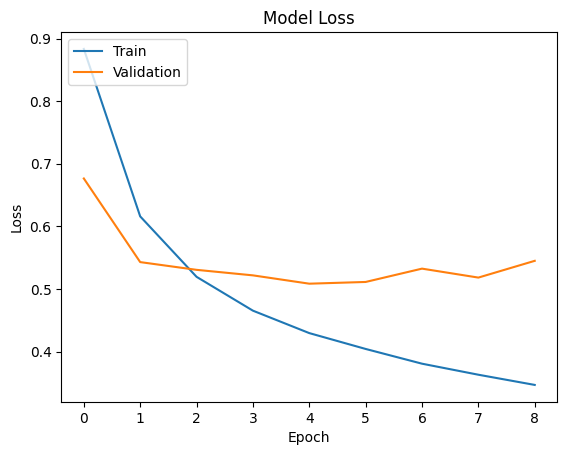

<Figure size 1200x400 with 0 Axes>

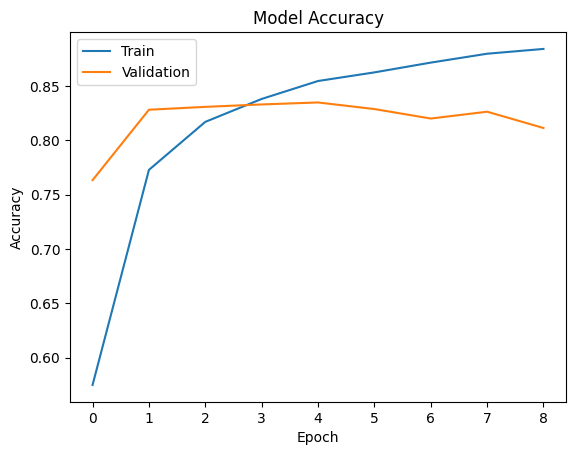

In [ ]:
plt.figure(figsize=(12, 4))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 4))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
loss, accuracy = model1.evaluate(X_test_vectorized, y_test_onehot)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


119/119 [==============================] - 1s 4ms/step - loss: 0.5474 - accuracy: 0.8112
Test Loss: 0.5473687052726746
Test Accuracy: 0.811216413974762


History:

Model0:
No regularization, only early stopping

Överträning: epok 1.
Test Loss: 0.5076591372489929
Test Accuracy: 0.8159557580947876


---
Model1:
dropout: (0.5 0.5 0.5)

Överträning: epok 1 väldigt lite
Test Loss: 0.5443338751792908
Test Accuracy: 0.7983149290084839


---
Model2.1:
dropout: (0.2 0.2 0.5)

Test Loss: 0.5342967510223389
Test Accuracy: 0.7980515956878662


---
Model2.2: --> best?
dropout (0.5 0.5 0.5 0.5) - one additional dropout(0.5) after the embedding layer.

Test Loss: 0.5489048957824707
Test Accuracy: 0.8098999261856079



119/119 [==============================] - 0s 3ms/step


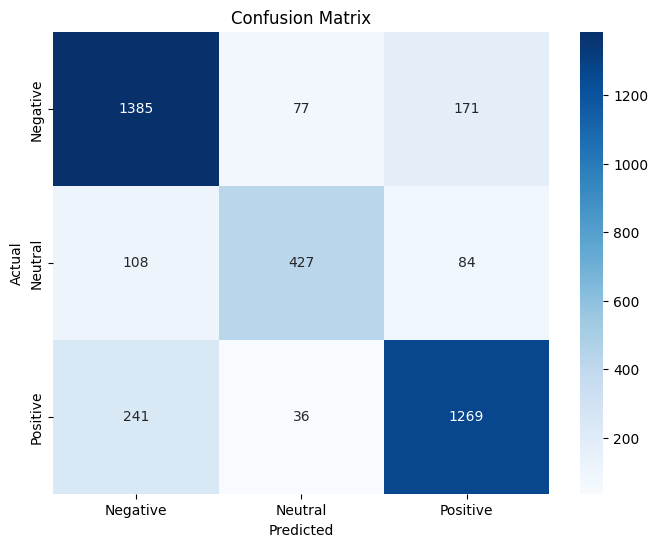

Classification Report:
               precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      1633
     Neutral       0.79      0.69      0.74       619
    Positive       0.83      0.82      0.83      1546

    accuracy                           0.81      3798
   macro avg       0.81      0.79      0.80      3798
weighted avg       0.81      0.81      0.81      3798

Accuracy for Negative: 0.8481
Accuracy for Neutral: 0.6898
Accuracy for Positive: 0.8208


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on the test set
y_pred = model1.predict(X_test_vectorized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_test_classes, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", class_report)

class_labels = ['Negative', 'Neutral', 'Positive']

# Calculate accuracy for each class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy for each class
for label, accuracy in zip(class_labels, class_accuracy):
    print(f'Accuracy for {label}: {accuracy:.4f}')




In [ ]:
# Find indices where the actual label was 'Neutral'
neutral_indices = np.where(y_test_classes == class_labels.index('Neutral'))[0]

# Display three examples where the actual label was 'Neutral'
for idx in neutral_indices[:6]:
    actual_label = class_labels[y_test_classes[idx]]
    predicted_label = class_labels[y_pred_classes[idx]]
    cleaned_text = X_test_preprocessed_lemmatization[idx]
    print(f'Actual Label: {actual_label}, Predicted Label: {predicted_label}')
    print(f'Actual Text: {X_test[idx]}')
    print(f'Cleaned Text: {cleaned_text}')
    print('-' * 50)

Actual Label: Neutral, Predicted Label: Neutral
Actual Text: #toiletpaper #dunnypaper #coronavirus #coronavirusaustralia #CoronaVirusUpdate #Covid_19 #9News  #Corvid19 #7NewsMelb #dunnypapergate #Costco    One week everyone buying baby milk powder the next everyone buying up toilet paper. https://t.co/ScZryVvsIh
Cleaned Text: toiletpaper dunnypaper coronavirus coronavirusaustralia coronavirusupdate dunnypapergate costco one week everyone buying baby milk powder next everyone buy toilet paper
--------------------------------------------------
Actual Label: Neutral, Predicted Label: Negative
Actual Text: Do you remember the last time you paid $2.99 a gallon for regular gas in Los Angeles?Prices at the pump are going down. A look at how the #coronavirus is impacting prices. 4pm @ABC7 https://t.co/Pyzq8YMuV5
Cleaned Text: remember last time pay gallon regular gas los angeles price pump go look coronavirus impact price user
--------------------------------------------------
Actual Label: Ne

## Hyperparameter tuning with Bayesian optimization (code was borrowed from professor's Lab 1 Colab)

In [ ]:
# Get Keras Tuner (if in colab)
import sys
if 'google.colab' in sys.modules:
  !pip install keras_tuner -q

import keras_tuner
print('Keras Tuner version:', keras_tuner.__version__)

# Get some tuner search functions
from keras_tuner.tuners import BayesianOptimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00
Keras Tuner version: 1.4.6


In [ ]:
# To have batch_size as a hyperparameter we need to define our own tuner
# In this case, we are basing it on the BayesianOptimization tuner found in
# https://keras-team.github.io/keras-tuner/documentation/tuners/#bayesianoptimization-class
class MyTuner(keras_tuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    # You can add additional HyperParameters for preprocessing and custom training loops
    # via overriding `run_trial`
    kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
from keras.optimizers import Adam
from keras.models import Model

def build_incremental_cnn_model(hp):
    i = keras.Input(shape=(X_train_vectorized.shape[1],))

    # Embedding layer with dropout
    x = Embedding(input_dim=vocab_size, output_dim=32)(i)
    x = Dropout(hp.Float('dropout_conv_0', min_value=0.01, max_value=0.5, step=0.01))(x)

    # Incremental convolutional layers
    for layer in range(1, hp.Int('num_conv_layers', min_value=1, max_value=4, step=1)):
        x = Conv1D(
            filters=hp.Int(f'conv_{layer}_filters', min_value=32, max_value=256, step=32),
            kernel_size=hp.Choice(f'conv_{layer}_kernel', values=[3, 5]),
            activation='relu',
            padding='same'
        )(x)
        x = MaxPooling1D()(x)
        x = Dropout(hp.Float(f'dropout_conv_{layer}', min_value=0.01, max_value=0.5, step=0.01))(x)

    # Global max pooling layer
    x = GlobalMaxPooling1D()(x)

    # Incremental dense layers
    for layer in range(1, hp.Int('num_dense_layers', min_value=1, max_value=4, step=1)):
        x = Dense(
            units=hp.Int(f'dense_{layer}_units', min_value=32, max_value=256, step=32),
            activation='relu'
        )(x)
        x = Dropout(hp.Float(f'dropout_dense_{layer}', min_value=0.01, max_value=0.5, step=0.01))(x)

    # Output layer
    outputs = Dense(3, activation='softmax')(x)

    model = Model(i, outputs)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Usage
# hp is a HyperParameters object
# model = build_incremental_cnn_model(hp)
# model.summary()


In [ ]:
# To get more stable results we are repeating the runs two times for each parameter setup
MAX_TRIALS = 20         # represents the number of hyperparameter combinations that will be tested by the tuner
EXECUTION_PER_TRIAL = 2 # the number of models that should be built and fit for each trial for robustness purposes

In [ ]:
# Bayesian search which also searches for batch_size
tuner = MyTuner(
    build_incremental_cnn_model, ##### Laboration: Change this to 'build_model_MyModel' #####
    max_trials=MAX_TRIALS,
    objective='val_accuracy',
    executions_per_trial=EXECUTION_PER_TRIAL,
    directory='output',
    overwrite=True,
    num_initial_points=10, # Start with 10 random points and then do more structured search
    project_name='TwitterSentimentAnalysisCovid'
)

In [ ]:
# Do the hyperparameter search
# I set the no of epochs to 6 to speed up the search in this excersise, better would have been 10
noepochauto = 6   ## Max number of epochs per trail (but we have early stopping so this max is probably not reached)
es = keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
# Note we do not need to_catagorical as we use loss='sparse_categorical_crossentropy'
tuner.search(X_train_vectorized, y_train_onehot,
             epochs=noepochauto,
             validation_data=(X_val_vectorized, y_val_onehot),
             callbacks=[es])

Trial 20 Complete [00h 03m 55s]
val_accuracy: 0.8144436478614807

Best val_accuracy So Far: 0.8347910642623901
Total elapsed time: 00h 44m 30s


In [ ]:
# Get the best model so far
model = tuner.get_best_models(num_models=1)[0]
# Dump the best hyperparameters found
vals = tuner.get_best_hyperparameters(num_trials=5)[4].values
for keys,values in vals.items():
    print('%20s = %3.4g' %(keys,values))

model.summary()

      dropout_conv_0 = 0.38
     num_conv_layers =   1
    num_dense_layers =   3
       learning_rate = 0.001
          batch_size = 320
       dense_1_units = 256
     dropout_dense_1 = 0.35
       dense_2_units =  32
     dropout_dense_2 = 0.04
       dense_3_units = 192
     dropout_dense_3 = 0.25
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1800)]            0         
                                                                 
 embedding (Embedding)       (None, 1800, 32)          16000032  
                                                                 
 dropout (Dropout)           (None, 1800, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, 1800, 224)         21728     
                                                                 
 max_pooling1d (MaxPoo

In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(X_test_vectorized, y_test_onehot)
print('Test accuracy: %.3f' % test_acc)


119/119 [==============================] - 1s 6ms/step - loss: 0.5126 - accuracy: 0.8104
Test accuracy: 0.810


In [ ]:
# Let us dump the n-best

if True:
  explorenbest = 5

  # Suppress warnings about optimizer state not being restored by keras.
  tf.get_logger().setLevel('ERROR')

  # Print a heading
  vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[0].values
  print('Test accuracy ', end = '')
  for keys,values in vals.items():
      print('%15s ' %(keys), end = '')
  print('\n')

  # Now print each trail on a seperate row from best to worst
  for ix in range(0,explorenbest):
    # evaluate this trail
    model = tuner.get_best_models(num_models=explorenbest)[ix]
    test_loss, test_acc = model.evaluate(X_test_vectorized, y_test_onehot, verbose=0)
    print('%15.3f ' % test_acc , end = '')
    # get this trail's hyperparameters
    vals = tuner.get_best_hyperparameters(num_trials=explorenbest)[ix].values
    for keys,values in vals.items():
      print('%15.4g ' %(values), end = '')
    # end this line and start the trail
    print()

Test accuracy  dropout_conv_0 num_conv_layers num_dense_layers   learning_rate      batch_size   dense_1_units dropout_dense_1   dense_2_units dropout_dense_2   dense_3_units dropout_dense_3  conv_1_filters   conv_1_kernel  dropout_conv_1  conv_2_filters   conv_2_kernel  dropout_conv_2  conv_3_filters   conv_3_kernel  dropout_conv_3 

          0.810            0.41               2               3           0.001             160             128            0.23             160            0.08             128            0.46             224               3            0.28              64               3            0.15             256               5            0.15 
          0.802            0.01               3               4           0.001             224             224            0.18             224            0.27              64            0.17             192               3            0.34             224               5            0.39             128               3       

Further train the model using the best parameters

In [ ]:
# Fine-tune the model using the best parameters found as we might not be fully trained
model = tuner.get_best_models(num_models=1)[0]

epochs = 30      ## (max) number of epoch to run
opt_batch_size = tuner.get_best_hyperparameters()[0]['batch_size']

# Set callback functions to early stop training
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=2, restore_best_weights = True)]

# Continue to train the model. (note that we are continuing from the training done during tuning)
history = model.fit(
  X_train_vectorized, y_train_onehot,
  epochs=epochs,
  batch_size=opt_batch_size,
  verbose = 1,
  validation_data=(X_val_vectorized, y_val_onehot),
  # initial_epoch=noepochauto, ## how to get this number???? from... "(root).optimizer.iter" maybe
  callbacks=callbacks
)

Epoch 1/30
206/206 [==============================] - 25s 112ms/step - loss: 0.3948 - accuracy: 0.8578 - val_loss: 0.4672 - val_accuracy: 0.8347
Epoch 2/30
206/206 [==============================] - 16s 78ms/step - loss: 0.3280 - accuracy: 0.8839 - val_loss: 0.4826 - val_accuracy: 0.8316
Epoch 3/30
206/206 [==============================] - 16s 76ms/step - loss: 0.2898 - accuracy: 0.9000 - val_loss: 0.5027 - val_accuracy: 0.8258
Epoch 3: early stopping


In [ ]:
# Evaluate the model.
test_loss, test_acc = model.evaluate(X_test_vectorized, y_test_onehot)
print('Test accuracy: %.3f' % test_acc)


119/119 [==============================] - 1s 6ms/step - loss: 0.5120 - accuracy: 0.8102
Test accuracy: 0.810


In [ ]:
# See what we got and how many parameters are used
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1800)]            0         
                                                                 
 embedding (Embedding)       (None, 1800, 32)          16000032  
                                                                 
 dropout (Dropout)           (None, 1800, 32)          0         
                                                                 
 conv1d (Conv1D)             (None, 1800, 224)         21728     
                                                                 
 max_pooling1d (MaxPooling1  (None, 900, 224)          0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 900, 224)          0         
                                                             

<Figure size 1200x400 with 0 Axes>

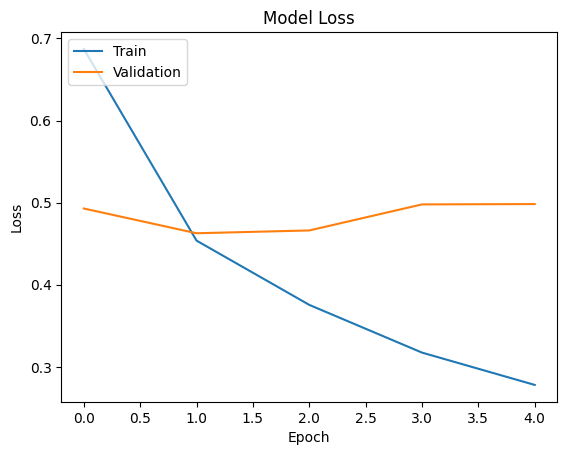

<Figure size 1200x400 with 0 Axes>

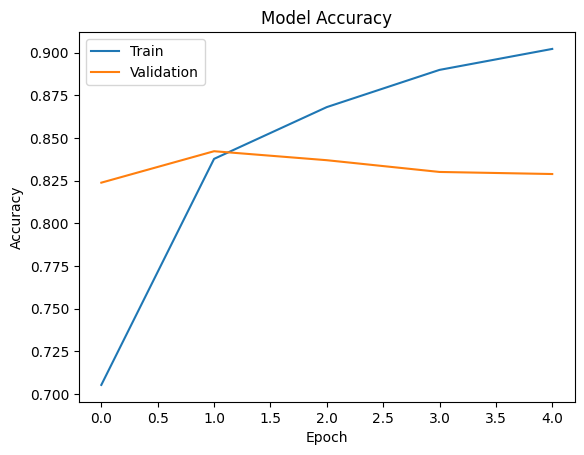

In [ ]:
plt.figure(figsize=(12, 4))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 4))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

119/119 [==============================] - 1s 5ms/step


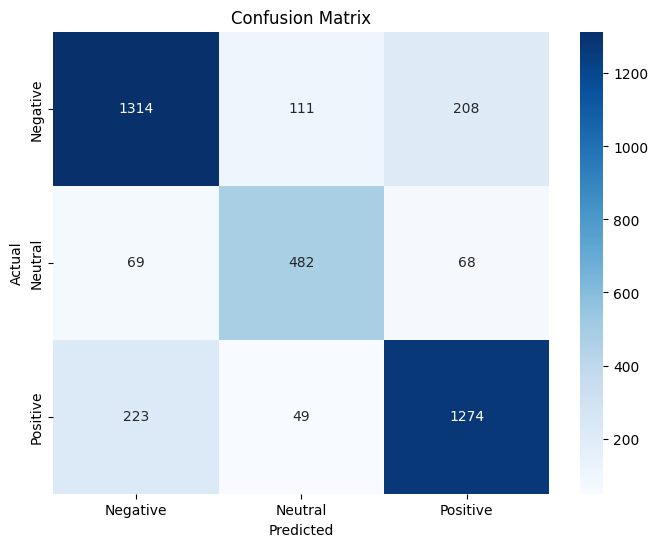

Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.80      0.81      1633
     Neutral       0.75      0.78      0.76       619
    Positive       0.82      0.82      0.82      1546

    accuracy                           0.81      3798
   macro avg       0.80      0.80      0.80      3798
weighted avg       0.81      0.81      0.81      3798

Accuracy for Negative: 0.8047
Accuracy for Neutral: 0.7787
Accuracy for Positive: 0.8241


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on the test set
y_pred = model.predict(X_test_vectorized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_test_classes, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", class_report)

class_labels = ['Negative', 'Neutral', 'Positive']

# Calculate accuracy for each class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy for each class
for label, accuracy in zip(class_labels, class_accuracy):
    print(f'Accuracy for {label}: {accuracy:.4f}')



## Using pre-trained embedding in an attempt to further improve the model

In [ ]:
import urllib
from zipfile import ZipFile

import gensim
import gensim.downloader as gsapi


In [ ]:
# Show all available models in gensim-data
print(list(gsapi.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
w2v = gsapi.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [ ]:
# Get vocabulary size and embedding dimension
vocab_size, embedding_dim = w2v.vectors.shape

# Create an embedding layer with weights initialized from GloVe vectors
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[np.array([w2v[word] if word in w2v else np.zeros(embedding_dim) for word in w2v.index_to_key])],
    trainable=True
)

In [ ]:
from keras.layers import Dropout

# Create the Conv1D model
model = Sequential()

i = keras.Input(shape=(X_train_vectorized.shape[1],))

# Embedding layer
x = embedding_layer(i)
x = Dropout(0.5)(x)

# Convolutional layers with max pooling
x = keras.layers.Conv1D(32, 3, activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = Dropout(0.5)(x)

x = keras.layers.Conv1D(64, 3, activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = Dropout(0.5)(x)

x = keras.layers.Conv1D(128, 3, activation='relu')(x)
x = keras.layers.MaxPooling1D()(x)
x = Dropout(0.5)(x)

# Global max pooling layer
x = keras.layers.GlobalMaxPooling1D()(x)

# Dense layers
x = keras.layers.Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Adding dropout before the final dense layer

outputs = keras.layers.Dense(3, activation='softmax')(x)

model2 = tf.keras.Model(i, outputs)

# Display the model summary
model2.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1800)]            0         
                                                                 
 embedding (Embedding)       (None, 1800, 25)          29837850  
                                                                 
 dropout_22 (Dropout)        (None, 1800, 25)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 1798, 32)          2432      
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 899, 32)           0         
 g1D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 899, 32)           0         
                                                           

In [ ]:
# Compile the model

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3,restore_best_weights = True)

start = time.time()

history = model2.fit(X_train_vectorized, y_train_onehot,
                      epochs=150,
                      validation_data=(X_val_vectorized, y_val_onehot),
                      batch_size=32,
                      callbacks=[early_stopping])

end = time.time()
print(f"Time to run: {end - start:.1f}",)


Epoch 1/150
1132/1132 [==============================] - 31s 25ms/step - loss: 0.7922 - accuracy: 0.6588 - val_loss: 0.6694 - val_accuracy: 0.8044
Epoch 2/150
1132/1132 [==============================] - 18s 16ms/step - loss: 0.5131 - accuracy: 0.8211 - val_loss: 0.6093 - val_accuracy: 0.8232
Epoch 3/150
1132/1132 [==============================] - 17s 15ms/step - loss: 0.4720 - accuracy: 0.8378 - val_loss: 0.5936 - val_accuracy: 0.8194
Epoch 4/150
1132/1132 [==============================] - 18s 15ms/step - loss: 0.4485 - accuracy: 0.8465 - val_loss: 0.5780 - val_accuracy: 0.8220
Epoch 5/150
1132/1132 [==============================] - 17s 15ms/step - loss: 0.4352 - accuracy: 0.8505 - val_loss: 0.6015 - val_accuracy: 0.8234
Epoch 6/150
1132/1132 [==============================] - 17s 15ms/step - loss: 0.4285 - accuracy: 0.8543 - val_loss: 0.5741 - val_accuracy: 0.8204
Epoch 7/150
1132/1132 [==============================] - 17s 15ms/step - loss: 0.4226 - accuracy: 0.8555 - val_loss: 0

In [ ]:
# Evaluate the model.
test_loss, test_acc = model2.evaluate(X_test_vectorized, y_test_onehot)
print('Test accuracy: %.3f' % test_acc)


119/119 [==============================] - 0s 4ms/step - loss: 0.5626 - accuracy: 0.8057
Test accuracy: 0.806


<Figure size 1200x400 with 0 Axes>

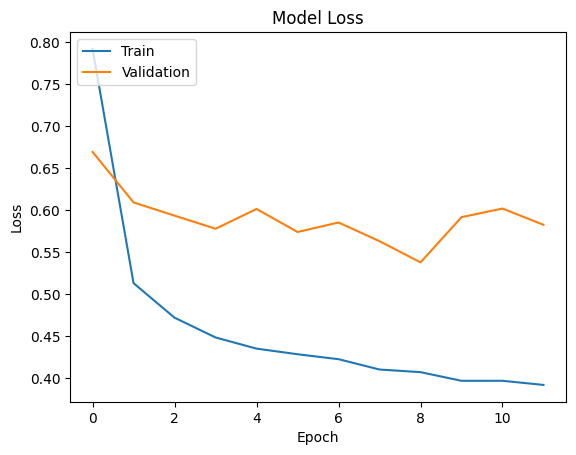

<Figure size 1200x400 with 0 Axes>

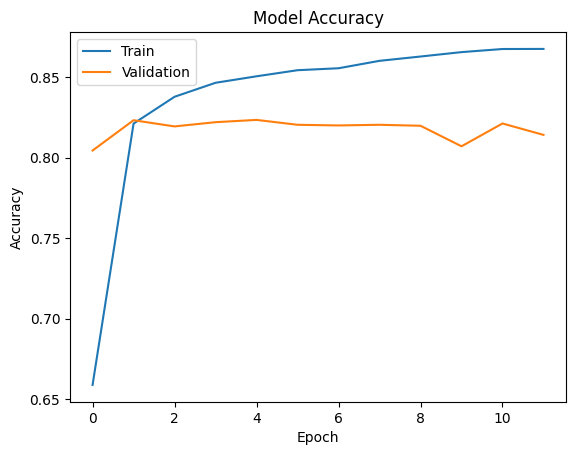

In [ ]:
plt.figure(figsize=(12, 4))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 4))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

119/119 [==============================] - 1s 4ms/step


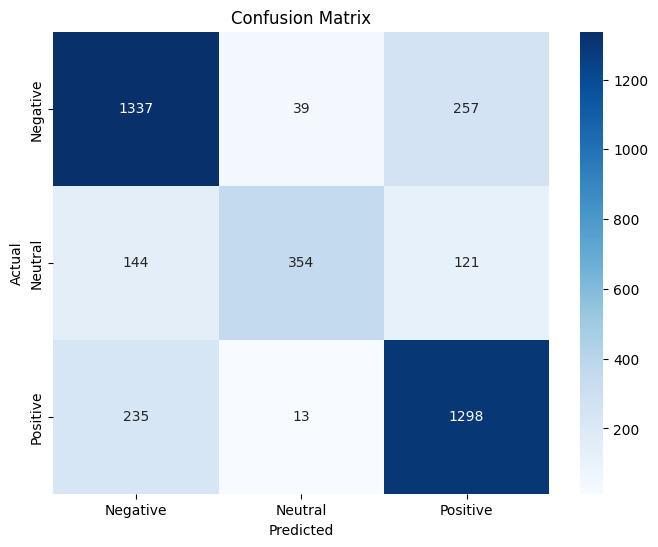

Classification Report:
               precision    recall  f1-score   support

    Negative       0.78      0.82      0.80      1633
     Neutral       0.87      0.57      0.69       619
    Positive       0.77      0.84      0.81      1546

    accuracy                           0.79      3798
   macro avg       0.81      0.74      0.76      3798
weighted avg       0.79      0.79      0.78      3798

Accuracy for Negative: 0.8187
Accuracy for Neutral: 0.5719
Accuracy for Positive: 0.8396


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Predictions on the test set
y_pred = model2.predict(X_test_vectorized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test_onehot, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_test_classes, y_pred_classes, target_names=['Negative', 'Neutral', 'Positive'])
print("Classification Report:\n", class_report)

class_labels = ['Negative', 'Neutral', 'Positive']

# Calculate accuracy for each class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print accuracy for each class
for label, accuracy in zip(class_labels, class_accuracy):
    print(f'Accuracy for {label}: {accuracy:.4f}')

